## Mount drive

In [1]:
 from google.colab import drive
 drive.mount('/content/gdrive')

Mounted at /content/gdrive


## GluonTS Dependencies
Run pip commad and then restart runtime to reload libraries such as Pandas to appropriate version. 

In [2]:
!pip install -q --upgrade mxnet==1.6 gluonts

     |████████████████████████████████| 68.7MB 63kB/s 
     |████████████████████████████████| 430kB 47.2MB/s 
     |████████████████████████████████| 8.7MB 46.1MB/s 
     |████████████████████████████████| 194kB 52.6MB/s 
     |████████████████████████████████| 92kB 9.1MB/s 
     |████████████████████████████████| 10.1MB 40.3MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.0.5 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement holidays>=0.10.2, but you'll have holidays 0.9.12 which is incompatible.


In [1]:
# Third-party imports. Pandas version should be 1.05
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

assert pd.__version__ == "1.0.5", "Pandas version is not 1.05"
 

## Load data

In [2]:
tf = pd.read_csv("gdrive/My Drive/data/shorelines/shoreline-positions-preprocessed-sample.csv", index_col=0)
tf.shape

(1000, 33)

## Define GluonTS parameters

In [21]:
metadata = {'num_series': len(tf),
            'num_steps': len(tf.columns),
            'prediction_length': 7,
            'freq': '1Y',
            'start': [pd.Timestamp("01-01-1984", freq='1Y') for _ in range(len(tf))],
            'item_id': tf.index.values
            }

## Load data into GluonTS

In [20]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset


[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

In [12]:
tf_values = tf.to_numpy()

(1000, 33)

In [35]:
train_ds = ListDataset(
    [
     {
         FieldName.TARGET: target,
         FieldName.START: start,
         FieldName.ITEM_ID: item_id
      }
     
     for (target, start, item_id) in zip(tf_values[:, :-metadata['prediction_length']],
                                        metadata['start'], 
                                        metadata['item_id'])
    ], freq=metadata['freq'])

test_ds = ListDataset(
    [
     {
         FieldName.TARGET: target,
         FieldName.START: start,
         FieldName.ITEM_ID: item_id
      }
     
     for (target, start, item_id) in zip(tf_values,
                                        metadata['start'], 
                                        metadata['item_id'])
    ], freq=metadata['freq'])

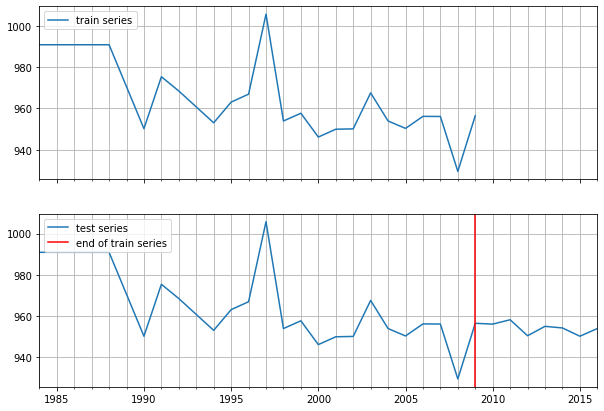

In [37]:
from gluonts.dataset.util import to_pandas


train_entry = next(iter(train_ds))
train_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

### GluonTS Transformations




In [39]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

transformation = create_transformation(
    metadata['freq'], 
    metadata['prediction_length'] * 2, # can be any appropriate value
    metadata['prediction_length']
    )
# only works when dynamic/static features included
train_tf = transformation(iter(train_ds), is_train=True)

### Get estimator and predictor


In [51]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=metadata['prediction_length'],
    context_length=metadata['prediction_length'] * 2,
    freq=metadata['freq'],
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100
                   )
)

predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 104.06it/s, epoch=5/5, avg_epoch_loss=5.71]


### Save model

In [ ]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

### Load model

In [ ]:
# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

### Inference

In [52]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

# first entry of the time series list
ts_entry = tss[0]
forecast_entry =  forecasts[0]
test_ds_entry = next(iter(test_ds))

# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

# first 5 values
test_ds_entry['target'][:5]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 7)
Start date of the forecast window: 2010-12-31 00:00:00
Frequency of the time series: 1Y


In [53]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [941.8658  965.59406 960.531   947.5511  948.02515 940.98096 952.22687]
0.5-quantile (median) of the future window:
 [941.0319  961.11066 964.3043  953.3675  952.5109  949.6033  951.08673]


### Plot forecast


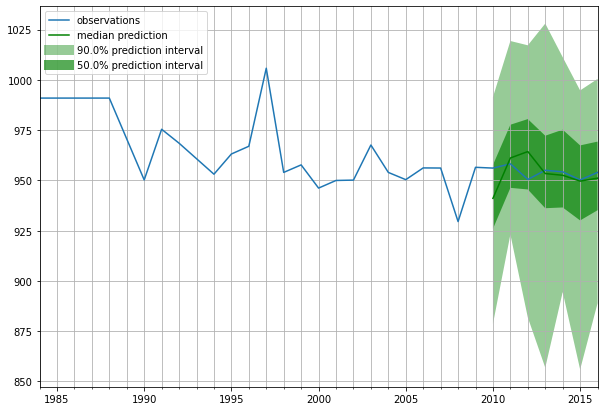

In [56]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 100 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

### Evaluation


In [57]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 1000/1000 [00:00<00:00, 28632.21it/s]


{
    "MSE": 6391.338034248891,
    "abs_error": 217090.25820541382,
    "abs_target_sum": 5354350.343623638,
    "abs_target_mean": 764.9071919462335,
    "seasonal_error": 14.578806050720202,
    "MASE": 2.3501359099974204,
    "MAPE": 0.13506944354356415,
    "sMAPE": 0.05707786750929208,
    "OWA": NaN,
    "MSIS": 40.2175582848051,
    "QuantileLoss[0.1]": 158112.74107139112,
    "Coverage[0.1]": 0.13542857142857131,
    "QuantileLoss[0.5]": 217090.2578136623,
    "Coverage[0.5]": 0.6034285714285702,
    "QuantileLoss[0.9]": 156623.5815987587,
    "Coverage[0.9]": 0.8808571428571427,
    "RMSE": 79.94584438386332,
    "NRMSE": 0.10451705151372512,
    "ND": 0.04054464954164629,
    "wQuantileLoss[0.1]": 0.029529771293296793,
    "wQuantileLoss[0.5]": 0.0405446494684812,
    "wQuantileLoss[0.9]": 0.029251649882282692,
    "mean_wQuantileLoss": 0.033108690214686896,
    "MAE_Coverage": 0.052666666666666286
}


In [58]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,BOX_105_093_46,77.221549,38.615173,6678.055176,954.007882,12.249053,0.450358,0.005783,0.005787,NaN,17.044654,58.271838,0.000000,38.615173,0.285714,55.284766,1.0
1,BOX_138_573_303,1597.511300,235.398987,5343.153320,763.307617,14.719092,2.284681,0.044739,0.043411,NaN,10.646399,117.538782,0.571429,235.398987,0.857143,91.174170,1.0
2,BOX_173_047_80,48.342739,40.101440,3980.696289,568.670898,12.684817,0.451625,0.010097,0.010130,NaN,8.469246,37.550684,0.000000,40.101440,0.142857,25.699695,1.0
3,BOX_166_460_7,21059.395089,870.254578,2806.258301,400.894043,59.547017,2.087797,0.310030,0.257193,NaN,65.057348,1371.899854,0.857143,870.254608,1.000000,197.210095,1.0
4,BOX_137_207_4,329.846401,80.977112,5866.874023,838.124860,12.568298,0.920424,0.014014,0.013804,NaN,12.673208,46.768274,0.142857,80.977112,0.571429,53.706799,1.0


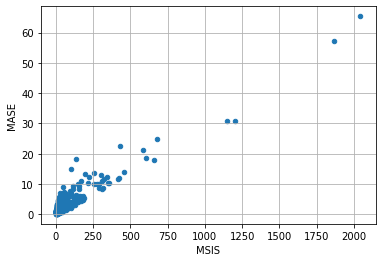

In [59]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()